In [1]:
# Import dependencies
import nibabel as nib
import numpy as np
import cv2
import scipy.io
import os
import imageio
from PIL import Image
import matplotlib.pyplot as plt
from utils import rotate

# Define file names
SAMPLE_NAME = "DBS_bT20"
HULL_FILE_NAME = os.path.join(SAMPLE_NAME,"hull_rh.mat")
PRECT_FILE_NAME = os.path.join(SAMPLE_NAME,"rpreop_ct.nii")
POSTCT_FILE_NAME = os.path.join(SAMPLE_NAME,"rpostop_ct.nii")
FLUORO_FILE_NAME = os.path.join(SAMPLE_NAME,"fluoro20.tif")

# Read .mat file of mask indices
hull = scipy.io.loadmat(HULL_FILE_NAME)
points_hull=np.array(hull['mask_indices'])

# Read pre op CT
prect = nib.load(PRECT_FILE_NAME)
prect_data = np.nan_to_num(np.array(prect.get_fdata()))
Tmatrix = np.transpose(prect.affine)

# Read post op CT
postct = nib.load(POSTCT_FILE_NAME)
postct_data = np.nan_to_num(np.array(postct.get_fdata()))
print(postct_data.shape)

# Read fluoroscopy image
fluoror = imageio.imread(FLUORO_FILE_NAME)
fluoro = cv2.cvtColor(fluoror, cv2.COLOR_BGR2GRAY)

(256, 256, 192)


(1222, 1187)


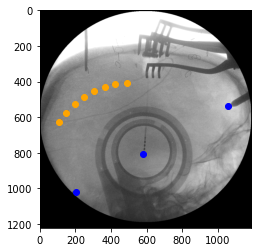

In [2]:
# Define ideal pin, DBS lead, and electrode inputs from pipeline script for this patient

# Format inputs as follows: pin left, pin right, DBS lead

pins_ct = np.array([[73, 73.0368, 52],[209, 147.6262207, 54], [147.276, 114, 85]])

pins_fl = np.array([[542, 1019],[1399, 539], [922,805]])

coords_2d = np.array([[109,626],[150,575],[196,525],[247,485],[303,452],[366,430],[423,413],[490,405]])

# Subtract 340 from x-axis to cut out GUI section of fluoro image

pins_flx = np.array([x - 340 for x in pins_fl[:,0]])
pins_fl = np.array([[pins_flx[0],pins_fl[0,1]], [pins_flx[1],pins_fl[1,1]], [pins_flx[2], pins_fl[2,1]]])

# Define ground truth transformed electrode coordinates

aligned_coords_gt = np.array([[203,83.00006068],[198,76.00005692],[192,70.00005567],[185,64.00005567],[177,60.00005692],
                              [169,57.00005317],[161, 54.00004941],[151,53.00005442]])

# Trim the fluoroscopy image to remove the GUI section

fluorot = np.delete(fluoro, range(0,340),axis=1)

# Display the fluoroscopy image, electrode, and pin coordinates

plt.imshow(fluorot,cmap='gray')
plt.scatter(coords_2d[:,0], coords_2d[:,1], color='orange')
plt.scatter(pins_fl[:,0],pins_fl[:,1], color='blue')
print(fluorot.shape)

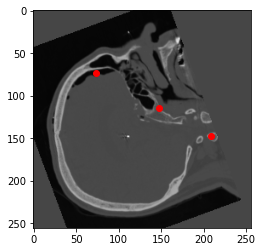

In [3]:
# Diplay approximate CT slice with pins and DBS lead coordinates
sl_num = np.array([pins_ct[:,2]])
sl = postct_data[:, :, int(sl_num[0,2])]
plt.imshow(sl,cmap='gray')
plt.scatter(pins_ct[:,0], pins_ct[:,1],color='red')

[[ 202 1019]
 [1059  539]
 [ 582  405]]
[[ 568.4609375   758.6511    ]
 [1217.6484375   914.50126551]
 [1023.01278125  458.5859375 ]]
(256, 256)


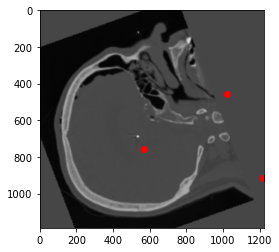

In [4]:
# 1. Preprocess the CT images and pin/DBS lead coordinates to match fluoro images

# Find the scaling factor
img_shape = (256, 256)
reshaped_img_shape = (1222, 1187)
scale = np.divide(reshaped_img_shape, img_shape)

sl_num = np.array([pins_ct[:,2]])
sl_resized = []
pins_ct2 = []
for i in range(len(pins_ct)):
    # Transform CT images
    sl = postct_data[:, :, int(sl_num[0,i])]
    sl2 = cv2.resize(sl,[fluorot.shape[0],fluorot.shape[1]])
    
    CT_new = np.multiply([pins_ct[i,0], pins_ct[i,1]], scale)
    pins_ct2.append(CT_new)

sl_resized = np.array(sl_resized)
pins_ct2 = np.array(pins_ct2)

# For CT DBS lead coordinate and fluoro DBS lead coordinate, move in the x- and y-axes to form the proper triangle for transformation

pins_fl = np.array([[pins_fl[0,0],pins_fl[0,1]],[pins_fl[1,0],pins_fl[1,1]],[pins_fl[2,0],pins_fl[2,1]-400]])
pins_ct2 = np.array([[pins_ct2[0,0]+220,pins_ct2[0,1]+420],[pins_ct2[1,0]+220,pins_ct2[1,1]+230],[pins_ct2[2,0]+320,pins_ct2[2,1]-70]])
print(pins_fl)
print(pins_ct2)

# Display transformed CT image and coordinates

plt.imshow(sl2,cmap='gray')
plt.scatter(pins_ct2[:,0], pins_ct2[:,1],color='red')
print(sl.shape)

[[ 568.4609375   758.6511    ]
 [1217.6484375   914.50126551]
 [1023.01278125  458.5859375 ]]
[[ 202 1019]
 [1059  539]
 [ 582  405]]


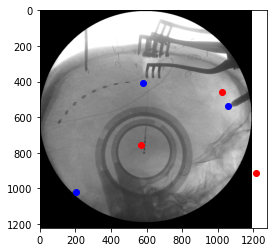

In [5]:
# Display the fluoroscopy image, fluoro and CT pins/DBS lead coordinates

plt.imshow(fluorot,cmap='gray')
plt.scatter(pins_ct2[:,0], pins_ct2[:,1],color='red')
plt.scatter(pins_fl[:,0], pins_fl[:,1],color='blue')
print(pins_ct2)
print(pins_fl)

[[ 5.24774001e-01 -4.15533711e-01  8.85885441e+02]
 [ 6.97279468e-01  9.20246553e-01 -3.19930567e+02]]


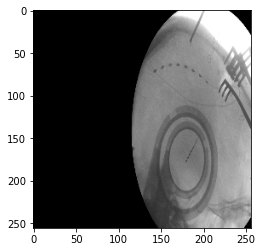

In [6]:
# 2. Find affine transformation matrix and perform affine transform to fluoroscopy image

# Find 2x3 affine transformation matrix
rows, cols = fluorot.shape
pins_fl = np.float32(pins_fl)
pins_ct2 = np.float32(pins_ct2)
M = cv2.getAffineTransform(pins_fl, pins_ct2)
print(M)

# Perform 2x3 affine transformation to fluoroscopy image, resize image to match 256x256 CT image shape
dst = cv2.warpAffine(fluorot, M, (rows, cols))
dst2 = cv2.resize(dst,[sl.shape[0],sl.shape[1]])

# Display affine transformed image
plt.imshow(dst2,cmap='gray')

# Find: what are the ideal inputs that will get me the precise electrode locations?

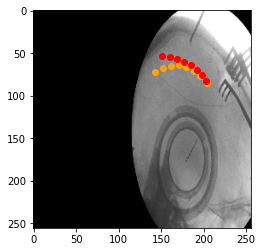

In [7]:
# 3. Apply transformation matrix and resize to all fluoro electrode coordinates to register them to CT image space

# Find the scaling factor
img_shape = (dst2.shape[1], dst2.shape[0])
reshaped_img_shape = (dst.shape[1], dst.shape[0])
scale = np.divide(img_shape, reshaped_img_shape)

# Apply transformation matrix
coords = []
for i in range(len(coords_2d)):
    pt = coords_2d[i]
    new_x = M[0,0]*pt[0] + M[0,1]*pt[1] + M[0,2]
    new_y = M[1,0]*pt[0] + M[1,1]*pt[1] + M[1,2]
    
    # Find resized coordinates in CT image space
    coord_new = np.multiply([new_x, new_y], scale)
    coords.append(coord_new)

coords = np.array(coords)

# Display predicted coordinates and ground truth coordinates on transformed fluoro image
plt.imshow(dst2,cmap='gray')
plt.scatter(coords[:,0],coords[:,1],color='orange')
plt.scatter(aligned_coords_gt[:,0],aligned_coords_gt[:,1],color='red')


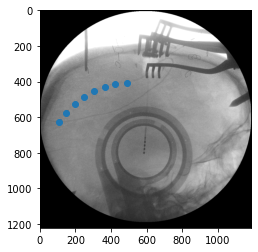

In [8]:
# Display original electrode coordinates on flouro
import matplotlib.pyplot as plt
plt.imshow(fluorot,cmap='gray')
plt.scatter(coords_2d[:,0], coords_2d[:,1])

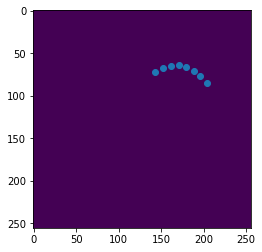

In [9]:
# Display predicted electrode coordinates on black image ('aligned' image)
# For now, this black image represents the 'aligned' image space
import matplotlib.pyplot as plt
plt.imshow(np.zeros([dst2.shape[0],dst2.shape[1]]))
plt.scatter(coords[:,0], coords[:,1])

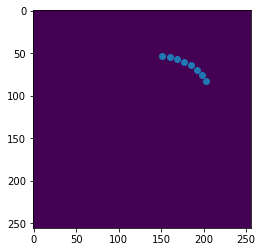

In [10]:
# Display the ground truth aligned electrode coordinates on black image
# For now, this black image represents the 'aligned' image space
import matplotlib.pyplot as plt
plt.imshow(np.zeros([dst2.shape[0],dst2.shape[1]]))
plt.scatter(aligned_coords_gt[:,0], aligned_coords_gt[:,1])

In [11]:
# Calculate mean absolute error between predicted and ground truth sets of aligned coordinates
MAE = np.mean(np.abs(aligned_coords_gt - coords))
MAE

22.621922448980573